In [1]:
from pandas import read_csv
from datetime import datetime


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import pandas as pd
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

In [2]:
data=pd.read_excel('US Data.xlsx')
data.head()

,Date,Open Price,Last Price,Financial Leverage,Volume,PE RATIO,Cash Flow Per Share,Price to Book Ratio,Dividend Per Share,SPX,VIX,PPUT
0,2014-02-03,71.8014,71.6471,1.7067,100620772,12.4425,3.6142,3.4514,0.4357,1741.89,21.44,593.43
1,2014-02-04,72.2643,72.6843,1.7067,94273543,12.6226,3.6142,3.5013,0.4357,1755.20,19.11,594.46
2,2014-02-05,72.3657,73.2271,1.7067,82322156,12.7169,3.6142,3.5275,0.4357,1751.64,19.95,594.10
3,2014-02-06,72.8657,73.2157,1.7067,64497223,12.7149,3.6142,3.5269,0.4357,1773.43,17.23,597.95
4,2014-02-07,74.4829,74.2400,1.7067,93638601,12.8928,3.6142,3.5763,0.4357,1797.02,15.29,603.01


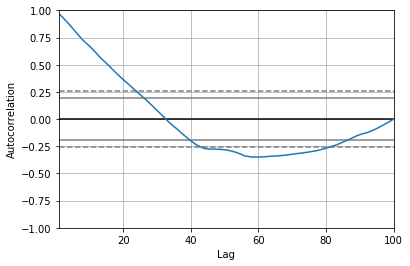

In [3]:
ts=data[['Date','Last Price']]
ts.set_index('Date', inplace=True)
autocorrelation_plot(ts.head(100))
pyplot.show()


In [4]:
ts.head()

,Last Price
Date,
2014-02-03,71.6471
2014-02-04,72.6843
2014-02-05,73.2271
2014-02-06,73.2157
2014-02-07,74.2400


In [5]:
#Intuitively, we know it is a non-stationary series, but let's have a ADfuller test anyway to verify.
#Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
#p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
from statsmodels.tsa.stattools import adfuller

result = adfuller(ts['Last Price'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])


ADF Statistic: -0.910913
p-value: 0.784358


In [6]:

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
 
    best_score, best_cfg = float("inf"), None
    for p in p_values:

        for d in d_values:
           
            for q in q_values:
       
                order = (p,d,q)
                print('order: ', order)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                        print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [7]:
def evaluate_arima_model(ts, order):

    X = ts['Last Price'].values
    size = int(len(X) * 0.8)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=order)
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    error = mean_squared_error(test, predictions)
    return error

In [ ]:
#from warnings import filterwarnings
#filterwarnings('ignore')

# evaluate parameters
p_values = [1, 2,3]
d_values = [1, 2]
q_values = [2,3,4]

evaluate_models(ts, p_values, d_values, q_values)



order:  (1, 1, 2)
order:  (1, 1, 3)
order:  (1, 1, 4)
order:  (1, 2, 2)


/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:221: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse o

order:  (1, 2, 3)


/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/Alex/anaconda3/envs/stan_env/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting he

order:  (1, 2, 4)


In [ ]:
# plot
pyplot.plot(test, label = 'actual')
pyplot.plot(predictions, color='red', label = 'prediction')
pyplot.legend()
pyplot.show()

In [30]:
model=ARIMA(train_data.values, order=(2,1,2))
m_fit=model.fit()
print(m_fit.summary())
forecast=m_fit.predict(len(test_data))
pyplot.plot(test_data, label='Test')
pyplot.plot(forecast, label='Prediction')
pyplot.show()

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.